In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import re
import matplotlib as mpl
from matplotlib.gridspec import GridSpec as GS

def get_cmap(cfile):
    cmap = []
    with open(cfile, 'r') as fc:
        for i, line in enumerate(fc.readlines()):
            line = line.strip()
            cmap.append(line)
    cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', cmap, 256)
    return cmap

wavefiles = r'data/ACOU_2D_WAVE_SNAPSHOTS/*.txt'
sfile = r'data/SOURCE_TIME_FUNCTION.txt'
vfile = r'data/vel.txt'
s = []
f = 20
with open(sfile, 'r') as fs:
    for i, line in enumerate(fs.readlines()):
        line = line.strip()
        tmp = line.split()
        if i < 1:
            nt, dt = int(tmp[0]), float(tmp[1])
        if i == 1:
            for ss in tmp:
                s.append(float(ss))
v = []
with open(vfile, 'r') as fv:
    for i, line in enumerate(fv.readlines()):
        line = line.strip()
        tmp = line.split()
        if i > 0:
            v.append([float(vv) for vv in tmp])

v = np.array(v)

# read in acoustic pressure data.
seis =r'data/acoustic_pressure.txt'
amp = []
receivers = []
with open(seis, 'r') as fseis:
    for i, line in enumerate(fseis.readlines()):
        line = line.strip()
        tmp = line.split()
        if i % 2 == 0:
            rx, rz, dx = int(tmp[1]), int(tmp[3]), float(tmp[5])
            receivers.append([rx, rz])
        else:
            amp.append([float(a) for a in tmp])
amp = np.array(amp)
receivers = np.array(receivers)
s = np.array(s)
t = np.arange(nt) * dt
plt.figure(figsize=(30, 9))
plt.subplot(121)
plt.plot(t, s, 'k', lw=2.5)
plt.xlabel('Time [s]', fontsize=25)
plt.ylabel('Amp.', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Source time function '+str(f)+' Hz', fontsize=30)
plt.subplot(122)
for i in range(len(amp[:, 0])):
    d = amp[i, :]
    d = d / max(abs(d))
    plt.plot(t, d*0.5+i, 'b', lw=2.5)
plt.xlabel('Time [s]', fontsize=25)
plt.ylabel('Amp.', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Acoustiuc Pressure [Pa]', fontsize=30)
plt.show()

font = {'family': 'serif',
       'color': 'darkred',
       'weight': 'bold',
       'size': 40}

count = 0
for f in glob.glob(wavefiles):
    ts = re.split('[._]', f)[-3: -1]
    ts = '.'.join(ts) + 's'
    u = []
    with open(f, 'r') as fin:
        for i, line in enumerate(fin.readlines()):
            line = line.strip()
            tmp = line.split()
            if i < 1:
                nt, nx, nz, sx, sz, f, dt, dx, wn = int(tmp[0]), int(tmp[1]), int(tmp[2]), int(tmp[3]), int(tmp[4]), float(tmp[5]), float(tmp[6]), float(tmp[7]), int(tmp[8])
#                 print('f: ',f, 'dx: ', dx)
            else:
                u.append([float(a) for a in tmp])
    x = np.arange(nx) * dx
    z = np.arange(nz) * dx
    u = np.array(u)
    
    fig = plt.figure(figsize=(30, 50))
    gs = GS(4, 2, figure=fig)
    
    # Acoustice wavefield.
    ax1 = fig.add_subplot(gs[0, 0])
    # plt.pcolormesh(x,  z, u, cmap=get_cmap(r'Dir_cmap/cmap_31.txt'), shading='gouraud', vmin=-0.14, vmax=0.14)
    vmax = max(abs(np.array([u.max(), u.min()])))
    plt.pcolormesh(x,  z, u, cmap=get_cmap(r'Dir_cmap/cmap_31.txt'), shading='gouraud', vmin=-vmax, vmax=vmax)
    ax= plt.gca()
    ax.invert_yaxis()
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_label_position('left')
#     cbar = plt.colorbar()
#     cbar.ax.tick_params(labelsize=25)
#     cbar.set_label('Amplitude',fontdict=font)
    plt.xlabel('X [m]', fontsize=50)
    plt.ylabel('Z [m]', fontsize=50)
    plt.xticks(np.arange(x[0], x[-1], 400), fontsize=45)
    plt.yticks(fontsize=45)
    plt.title('Wave field', fontsize=50)
    plt.scatter(sx*dx, sz*dx,  marker='*', s=1500, facecolor='r', edgecolor='c')
    plt.scatter(receivers[:, 0]*dx, receivers[:, 1]*dx,  marker='v', s=600, facecolor='c', edgecolor='r')
    
    
    # Velocity model.
    ax2 = fig.add_subplot(gs[0, 1])
    plt.pcolormesh(x,  z, v, cmap=get_cmap(r'Dir_cmap/cmap_39.txt'), shading='gouraud')
    ax= plt.gca()
    ax.invert_yaxis()
    ax.set_yticks([])
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=25)
    cbar.set_label('Velocity (m.s$^{-1}$)',fontdict=font)
    plt.xlabel('X [m]', fontsize=50)
    plt.xticks(np.arange(x[0], x[-1], 400), fontsize=45)
    plt.yticks(fontsize=45)
    plt.title('Velocity Model', fontsize=50)
    plt.scatter(sx*dx, sz*dx,  marker='*', s=1500, facecolor='k', edgecolor='c')
    plt.scatter(receivers[:, 0]*dx, receivers[:, 1]*dx,  marker='v', s=600, facecolor='k', edgecolor='r')
    
    # Time series of acoustic pressure.
    ax3 = fig.add_subplot(gs[1:, :])
    for i in range(len(amp[:, 0])):
        d = amp[i, :]
        d = d / max(abs(d)) * 0.7
        plt.plot(t[: count*wn], d[: count*wn]+i, 'b', lw=5)
        plt.ylim(-0.5, len(amp[:, 0])+0.5)
    plt.xlabel('Time [s]', fontsize=60)
    plt.ylabel('Receiver no.', fontsize=60)
    plt.xticks(fontsize=55)
    plt.yticks(fontsize=55)
    plt.xlim(-0.05, t[-1]*1.1)
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(12)
    ax.spines['left'].set_linewidth(12)
    ax.spines['top'].set_linewidth(12)
    ax.spines['right'].set_linewidth(12)
    plt.suptitle(ts, fontsize=70)
    plt.savefig('Snapshot_' + ts + '.jpg')
    count += 1

<Figure size 3000x900 with 2 Axes>

D:\Anaconda\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


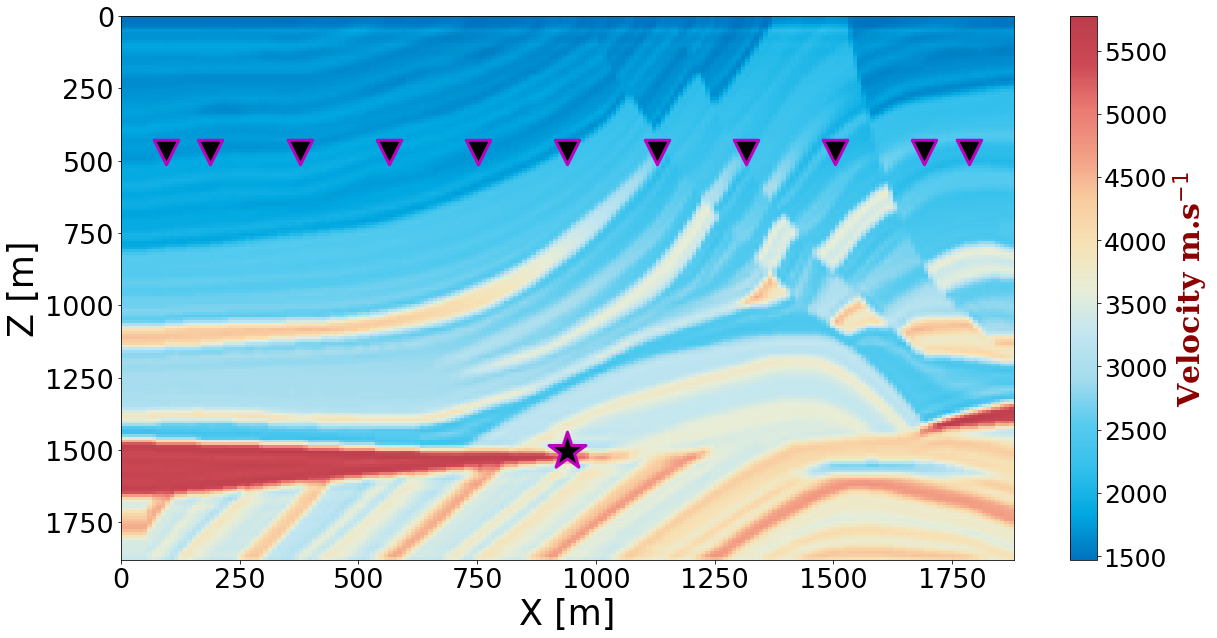

(201, 201)


In [14]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import matplotlib as mpl

def get_cmap(cfile):
    cmap = []
    with open(cfile, 'r') as fc:
        for i, line in enumerate(fc.readlines()):
            line = line.strip()
            cmap.append(line)
    cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', cmap, 256)
    return cmap

def resample_vel(data, x, z, xnew, znew):
    data = interpolate.interp2d(x, z, v, kind='cubic')
    data = data(xnew, znew)
    return data
def readin_model(fname):
    data = []
    with open(fname, 'r') as fd:
        for line in fd.readlines():
            line = line.strip()
            data.append([float(d) for d in line.split()])
    return np.array(data)
def down_sam(data, mk, nk):
    if mk < 1.001 or nk < 1.001:
        return []
    m = len(data[:, 0])
    n = len(data[0, :])
    mm = int(m/mk)
    nn = int(n/nk)
    data_down = np.zeros((m, nn))
    for i in range(mm):
        for j in range(nn):
            data_down[i, j] = data[i*int(mk), j*int(nk)]
    return data_down

nx = 201
nz = 201
f = 20
nt = 2501
dt = 0.001
stype = 0
b = 2
sx = int(nx*0.5)
sz = int(nz*0.8)
dx = 9.4
x = np.arange(nx) * dx
z = np.arange(nz) * dx

# Setting receivers.
receivers = np.array([[10, 50],
            [20,  50],
            [40,  50],
            [60,  50],
            [80,  50],
            [100, 50],
            [120, 50],
            [140, 50],
            [160, 50],
            [180, 50],
            [190, 50]])
with open('data/receivers.txt', 'w') as fr:
    for i in range(len(receivers[:, 0])):
        fr.write(str(receivers[i, 0]) + '   ' + str(receivers[i, 1]) + '\n')
# modelfile = r'Model_06.jpg'
# img = cv2.imread(modelfile)
# print('redin data shape: ', img.shape)
# kernel = np.ones((25, 25), np.float32)/50
# img = cv2.filter2D(img,-1,kernel)
# w = [0.3, 0.59, 0.11]
# img1 = np.zeros((len(img[:, 0, 0]), len(img[0, :, 0])))
# for i in range(3):
#     img1 += w[i] * img[:, :, i]
# v = img1*5 + 2000
v = readin_model('marmousi_5m_interval.txt')
v = down_sam(v, 3, 8)
xx = np.arange(len(v[0, :])) * dx
zz= np.arange(len(v[:, 0])) * dx
v = resample_vel(v, xx, zz, x, z)
v[v<(v.max()*0.25)] = v.max()*0.25*np.random.random() + 1500

font = {'family': 'serif',
       'color': 'darkred',
       'weight': 'bold',
       'size': 30}
plt.figure(figsize=(20, 10))
plt.pcolormesh(x, z, v, cmap=get_cmap(r'Dir_cmap/cmap_01.txt'))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Velocity m.s$^{-1}$',fontdict=font)
plt.scatter(sx*dx, sz*dx, marker='*', s=1500, facecolor='k', edgecolor='m', lw=3)
plt.scatter(receivers[:, 0]*dx, receivers[:, 1]*dx, marker='v', s=600, facecolor='k', edgecolor='m', lw=3)
plt.xlabel('X [m]', fontsize=35)
plt.ylabel('Z [m]', fontsize=35)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
ax = plt.gca()
ax.invert_yaxis()
plt.savefig('mar_vel.jpg')
plt.show()
print(v.shape)
with open(r'data/vel.txt', "w") as fin:
    fin.write(str(nt)+' '+str(nx)+' '+str(nz)+' '+str(sx)+' '+str(sz)+' '+str(stype)+' '+str(b)+' '+str(f)+' '+str(dt)+'\n')
    for i in range(nz):
        out = ' '.join([str(s) for s in v[i, :]])
        fin.write(out + '\n')


read in data shape:  (300, 300)


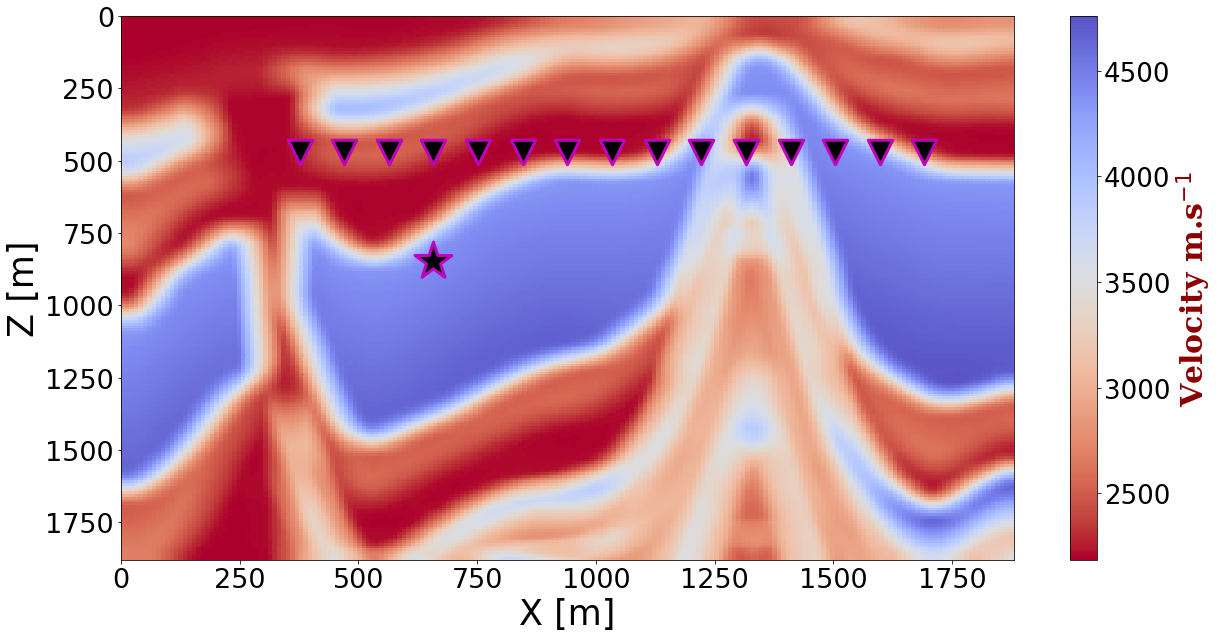

(201, 201)


In [74]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import cv2
import matplotlib as mpl
from PIL import Image

def get_cmap(cfile, rev=False):
    cmap = []
    with open(cfile, 'r') as fc:
        for i, line in enumerate(fc.readlines()):
            line = line.strip()
            cmap.append(line)
    if rev:
        cmap = cmap[::-1]
    cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', cmap, 256)
    return cmap

def resample_vel(data, x, z, xnew, znew):
    if len(x) >= 201 and len(z) >= 201:
        return data[: 201, : 201]
    data = interpolate.interp2d(x, z, v, kind='cubic')
    data = data(xnew, znew)
    return data
def readin_model(fname):
    data = []
    with open(fname, 'r') as fd:
        for line in fd.readlines():
            line = line.strip()
            data.append([float(d) for d in line.split()])
    return np.array(data)
def down_sam(data, mk, nk):
    if mk < 1.001 or nk < 1.001:
        return []
    m = len(data[:, 0])
    n = len(data[0, :])
    mm = int(m/mk)
    nn = int(n/nk)
    data_down = np.zeros((m, nn))
    for i in range(mm):
        for j in range(nn):
            data_down[i, j] = data[i*int(mk), j*int(nk)]
    return data_down

nx = 201
nz = 201
f = 20
nt = 2001
dt = 0.001
stype = 0
b = 2
sx = int(nx*0.35)
sz = int(nz*0.45)
dx = 9.4
x = np.arange(nx) * dx
z = np.arange(nz) * dx

# Setting receivers.
rz = 50
receivers = np.zeros((15, 2), dtype=np.int)
for i in range(15):
    receivers[i, :] = np.array([(i+1)*10+30, rz])
with open('data/receivers.txt', 'w') as fr:
    for i in range(len(receivers[:, 0])):
        fr.write(str(receivers[i, 0]) + '   ' + str(receivers[i, 1]) + '\n')
modelfile = r'Model_06.jpg'
img = img = np.array( Image.open(modelfile).convert('L'), 'f' )
print('read in data shape: ', img.shape)
v = img / abs(img).max() * 1500 + 1000
x1 = np.arange(len(v[0, :])) * dx
z1 = np.arange(len(v[:, 0])) * dx
v = resample_vel(v, x1, z1, x, z)
kernel = np.ones((10, 10), np.float32)/50
v = cv2.filter2D(v,-1,kernel)

font = {'family': 'serif',
       'color': 'darkred',
       'weight': 'bold',
       'size': 30}
plt.figure(figsize=(20, 10))
plt.pcolormesh(x, z, v, cmap=get_cmap(r'Dir_cmap/cmap_39.txt', rev=False))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=26)
cbar.set_label('Velocity m.s$^{-1}$',fontdict=font)
plt.scatter(sx*dx, sz*dx, marker='*', s=1500, facecolor='k', edgecolor='m', lw=3)
plt.scatter(receivers[:, 0]*dx, receivers[:, 1]*dx, marker='v', s=600, facecolor='k', edgecolor='m', lw=3)
plt.xlabel('X [m]', fontsize=35)
plt.ylabel('Z [m]', fontsize=35)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
ax = plt.gca()
ax.invert_yaxis()
plt.savefig('mar_vel.jpg')
plt.show()
print(v.shape)
with open(r'data/vel.txt', "w") as fin:
    fin.write(str(nt)+' '+str(nx)+' '+str(nz)+' '+str(sx)+' '+str(sz)+' '+str(stype)+' '+str(b)+' '+str(f)+' '+str(dt)+'\n')
    for i in range(nz):
        out = ' '.join([str(s) for s in v[i, :]])
        fin.write(out + '\n')

### import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import cv2
import matplotlib as mpl

def get_cmap(cfile):
    cmap = []
    with open(cfile, 'r') as fc:
        for i, line in enumerate(fc.readlines()):
            line = line.strip()
            cmap.append(line)
    cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', cmap, 256)
    return cmap
nx = 201
nz = 201
f = 25
nt = 1001
dt = 0.001
stype = 0
b = 2
sx = int(nx*0.5)
sz = 100
dx = 9.4
x = np.arange(nx) * dx
z = np.arange(nz) * dx

# Setting receivers.
receivers = np.ones((15, 2), dtype=np.int)
for i in range(15):
    receivers[i, :] = np.array([(i+1)*10+30, 20])
with open('data/receivers.txt', 'w') as fr:
    for i in range(len(receivers[:, 0])):
        fr.write(str(receivers[i, 0]) + '   ' + str(receivers[i, 1]) + '\n')
v = np.ones((nz, nx)) * 2000
# for i in range(6):
#     v[i*30: (i+1)*30, :] = i*500 + 2000
font = {'family': 'serif',
       'color': 'darkred',
       'weight': 'bold',
       'size': 30}
plt.figure(figsize=(20, 10))
plt.pcolormesh(x, z, v, cmap=get_cmap(r'Dir_cmap/cmap_11.txt'))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Velocity m.s$^{-1}$',fontdict=font)
plt.scatter(sx*dx, sz*dx, marker='*', s=1500, facecolor='k', edgecolor='m', lw=3)
plt.scatter(receivers[:, 0]*dx, receivers[:, 1]*dx, marker='v', s=600, facecolor='k', edgecolor='m', lw=3)
plt.xlabel('X [m]', fontsize=35)
plt.ylabel('Z [m]', fontsize=35)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
ax = plt.gca()
ax.invert_yaxis()
plt.savefig('mar_vel.jpg')
plt.show()
print(v.shape)
with open(r'data/vel.txt', "w") as fin:
    fin.write(str(nt)+' '+str(nx)+' '+str(nz)+' '+str(sx)+' '+str(sz)+' '+str(stype)+' '+str(b)+' '+str(f)+' '+str(dt)+'\n')
    for i in range(nz):
        out = ' '.join([str(s) for s in v[i, :]])
        fin.write(out + '\n')

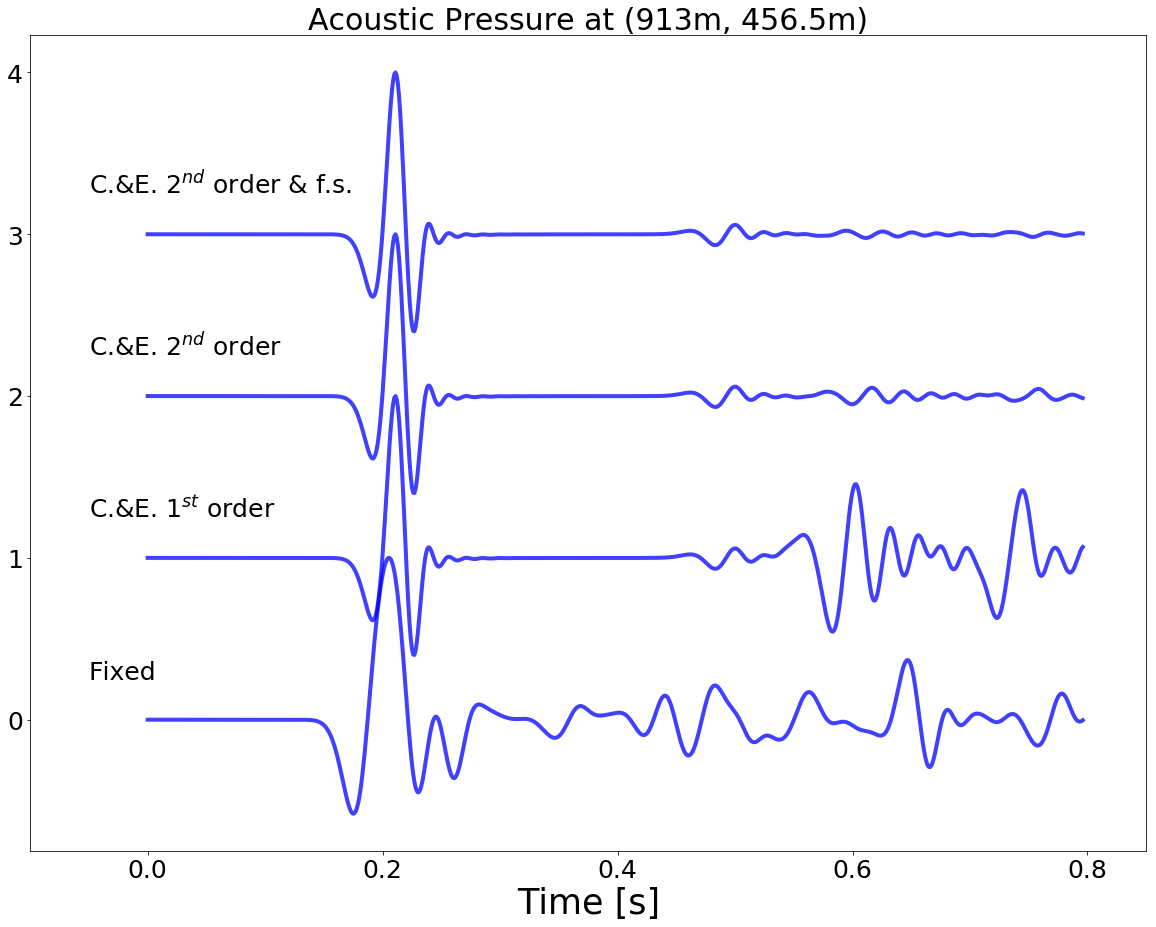

In [34]:
import numpy as np
import matplotlib.pyplot as plt

seis =r'data/seismograms-all.txt'
amp = []
with open(seis, 'r') as fseis:
    for line in fseis.readlines():
        line = line.strip()
        amp.append([float(a) for a in line.split()])
amp = np.array(amp)
condi = ['Fixed', 'C.&E. 1$^{st}$ order', 'C.&E. 2$^{nd}$ order', 'C.&E. 2$^{nd}$ order & f.s.']
m = len(amp[:, 0])
n = len(amp[0, :])
tt = np.arange(n) * 0.001
plt.figure(figsize=(20, 15))
for i in range(m):
    d = amp[i, :]
    d = d / max(abs(d))
    plt.plot(tt, d+i, 'b', lw=4, alpha=0.75)
    plt.text(-0.05, i+0.25, condi[i], fontsize=25)
plt.xlabel('Time [s]', fontsize=35)
#plt.ylabel('Z [m]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xlim(-0.1, 0.85)
plt.title('Acoustic Pressure at (913m, 456.5m)', fontsize=30)
plt.savefig('seismograms.jpg')
plt.show()    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

nx = 201
nz = 201
nt = 401
dt = 0.001
f = 15
c = 3000
dx = c*dt*8/3
A = dt*c/dx
sx = 100
sz = 100
x = np.arange(nx) * dx
z = np.arange(nz) * dx
t = np.arange(nt) * dt
T = 1/f
s= np.zeros(nt)
for i in range(nt):
    if i*dt <= T/2:
        s[i] = np.sin(2*np.pi*f*i*dt)**2
u = np.zeros((nt, nz, nx))
for i in range(1, nt-1):
    for j in range(1, nz-1):
        for k in range(1, nx-1):
            # absorbing boundary condition.
            u[i+1, 0, k] = A*u[i, 1, k] + (1-A)*u[i, 0, k]
            u[i+1, nz-1, k] = A*u[i, nz-2, k] + (1-A)*u[i, nz-1, k]
            u[i+1, j, 0] = A*u[i, j, 1] + (1-A)*u[i, j, 0]
            u[i+1, j, nx-1] = A*u[i, j, nx-2] + (1-A)*u[i, j, nx-1]
            if j == sz and k == sx:
                u[i+1, j, k] = s[i]
            else:
                u[i+1, j, k] = A**2 * (u[i, j+1, k]+u[i, j-1, k]+u[i, j, k+1]+u[i, j, k-1]-4*u[i, j, k]) + \
                                2*u[i, j, k] - u[i-1, j, k]
plt.figure(figsize=(17, 8))
plt.subplot(121)
plt.pcolormesh(x, z, u[200, :, :], cmap='bwr', shading='gouraud')
plt.xlabel('X [m]', fontsize=25)
plt.ylabel('Z [m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('0.2 s', fontsize=30)

plt.subplot(122)
plt.pcolormesh(x, z, u[400, :, :], cmap='bwr', shading='gouraud')
plt.xlabel('X [m]', fontsize=25)
plt.ylabel('Z [m]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('0.4 s', fontsize=30)
plt.suptitle('Clayton and Engquist ABC', fontsize=30)
plt.show()
            

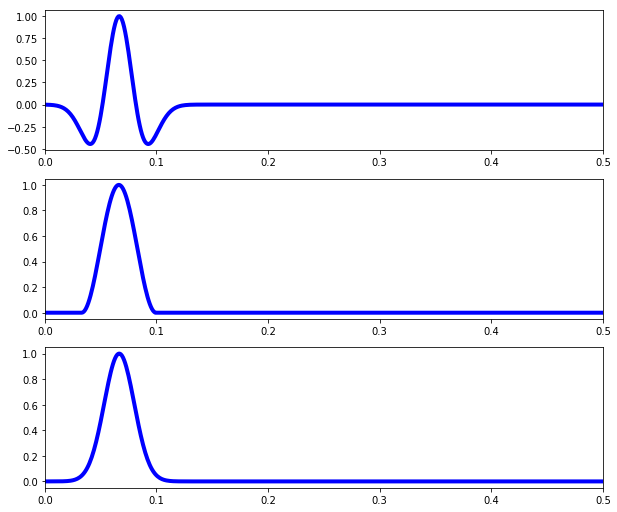

In [25]:
import numpy as np
import matplotlib.pyplot as plt

f = 15
dt = 0.001
t0 = 10
t = np.arange(0, t0+dt, dt)
t00 = 1/f
s1 = (1-2*(np.pi*f*(t-t00))**2) * np.exp(-(np.pi*f*(t-t00))**2)
s2 = np.zeros(len(t))
fi = int(1/f/dt)
s2[fi//2: fi+fi//2] = np.sin(np.pi*f*t[: fi])**2
s3 = np.exp(-(t-t00)**2*np.pi*f**2.5)

plt.figure(figsize=(10, 15))
plt.subplot(511)
plt.plot(t, s1, 'b', lw=4)
plt.xlim(0, 0.5)
plt.subplot(512)
plt.plot(t, s2, 'b', lw=4)
plt.xlim(0, 0.5)
plt.subplot(513)
plt.plot(t, s3, 'b', lw=4)
plt.xlim(0, 0.5)
plt.show()

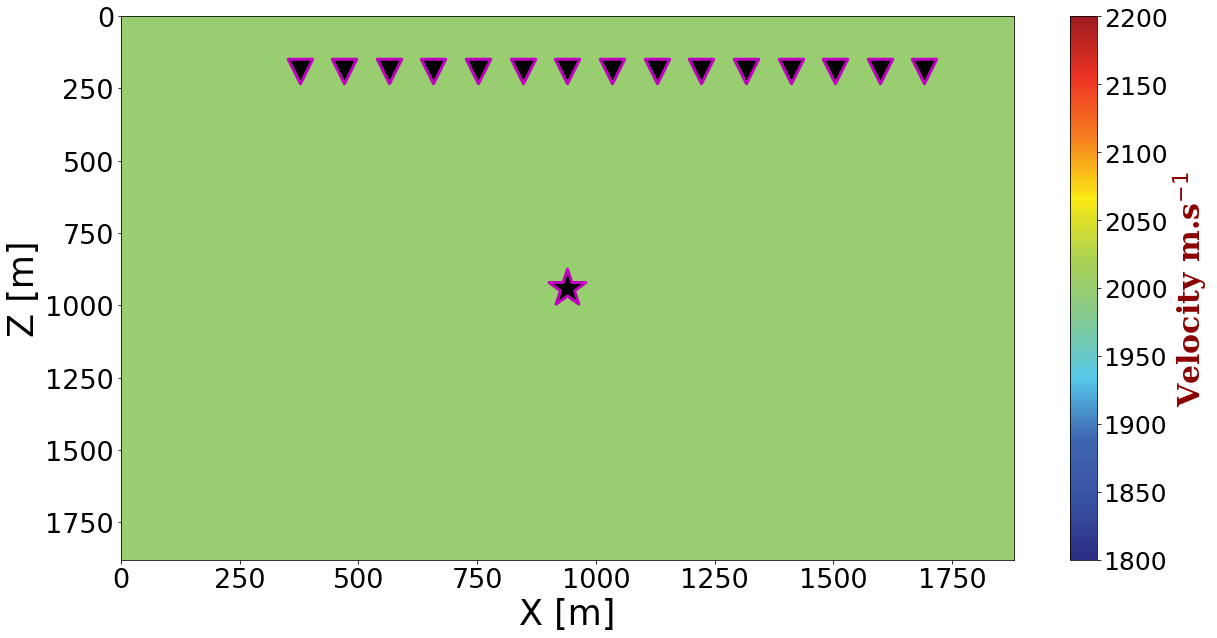

(201, 201)


In [36]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
import cv2
import matplotlib as mpl

def get_cmap(cfile):
    cmap = []
    with open(cfile, 'r') as fc:
        for i, line in enumerate(fc.readlines()):
            line = line.strip()
            cmap.append(line)
    cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', cmap, 256)
    return cmap
nx = 201
nz = 201
f = 50
nt = 1001
dt = 0.001
stype = 0
b = 2
sx = int(nx*0.5)
sz = 100
dx = 9.4
x = np.arange(nx) * dx
z = np.arange(nz) * dx

# Setting receivers.
receivers = np.ones((15, 2), dtype=np.int)
for i in range(15):
    receivers[i, :] = np.array([(i+1)*10+30, 20])
with open('data/receivers.txt', 'w') as fr:
    for i in range(len(receivers[:, 0])):
        fr.write(str(receivers[i, 0]) + '   ' + str(receivers[i, 1]) + '\n')
v = np.ones((nz, nx)) * 2000
# for i in range(6):
#     v[i*30: (i+1)*30, :] = i*500 + 2000
font = {'family': 'serif',
       'color': 'darkred',
       'weight': 'bold',
       'size': 30}
plt.figure(figsize=(20, 10))
plt.pcolormesh(x, z, v, cmap=get_cmap(r'Dir_cmap/cmap_11.txt'))
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=25)
cbar.set_label('Velocity m.s$^{-1}$',fontdict=font)
plt.scatter(sx*dx, sz*dx, marker='*', s=1500, facecolor='k', edgecolor='m', lw=3)
plt.scatter(receivers[:, 0]*dx, receivers[:, 1]*dx, marker='v', s=600, facecolor='k', edgecolor='m', lw=3)
plt.xlabel('X [m]', fontsize=35)
plt.ylabel('Z [m]', fontsize=35)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
ax = plt.gca()
ax.invert_yaxis()
plt.savefig('mar_vel.jpg')
plt.show()
print(v.shape)
with open(r'data/vel.txt', "w") as fin:
    fin.write(str(nt)+' '+str(nx)+' '+str(nz)+' '+str(sx)+' '+str(sz)+' '+str(stype)+' '+str(b)+' '+str(f)+' '+str(dt)+'\n')
    for i in range(nz):
        out = ' '.join([str(s) for s in v[i, :]])
        fin.write(out + '\n')

D:\Anaconda\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


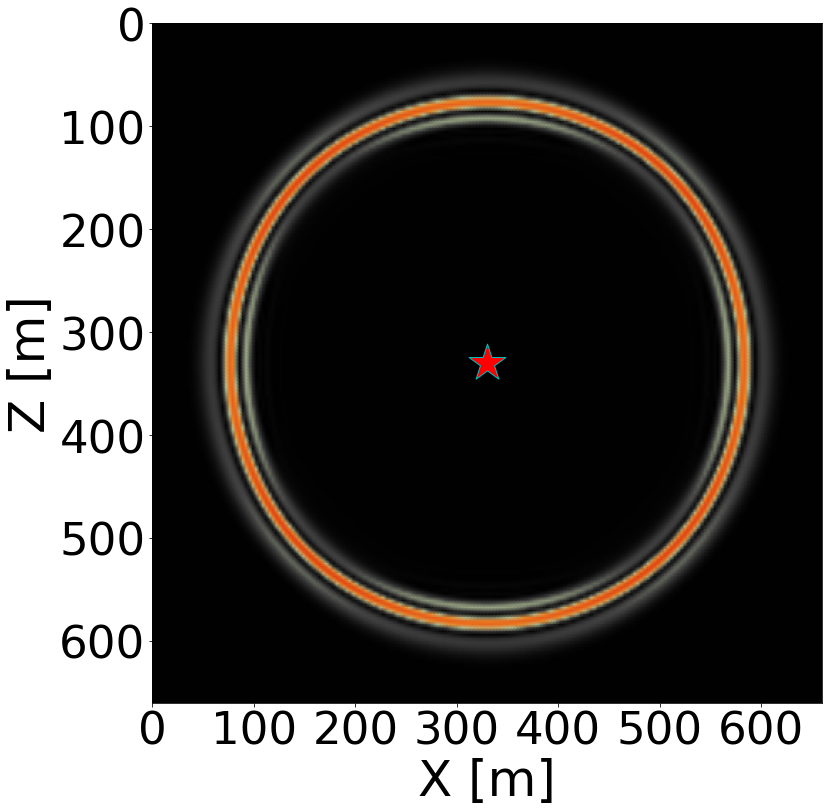

In [38]:
import numpy as np
import matplotlib.pyplot as plt

vfile = r'data/ACOU_2D_WAVE_SNAPSHOTS/ACOUTIC_WAVE_2D_VEL_0.150000.txt'
v = []
with open(vfile, 'r') as fv:
    for i, line in enumerate(fv.readlines()):
        line = line.strip()
        tmp = line.split()
        if 0 == i:
            dx, f = float(tmp[7]), float(tmp[5])
        if i > 0:
            v.append([float(vv) for vv in tmp])
v = np.array(v)
x = np.arange(len(v[0, :])) * dx
z = np.arange(len(v[:, 0])) * dx
plt.figure(figsize=(12, 12.5))
ax1 = fig.add_subplot(gs[0, 0])
vmax = max(abs(np.array([v.max(), v.min()])))
plt.pcolormesh(x,  z, v, cmap=get_cmap(r'Dir_cmap/cmap_31.txt'), shading='gouraud', vmin=-vmax, vmax=vmax)
ax= plt.gca()
ax.invert_yaxis()
ax.yaxis.set_ticks_position('left')
ax.yaxis.set_label_position('left')
plt.xlabel('X [m]', fontsize=50)
plt.ylabel('Z [m]', fontsize=50)
plt.xticks(np.arange(x[0], x[-1], 100), fontsize=45)
plt.yticks(fontsize=45)
# plt.title('Wave field', fontsize=50)
plt.scatter(sx*dx, sz*dx,  marker='*', s=1500, facecolor='r', edgecolor='c')
# plt.scatter(receivers[:, 0]*dx, receivers[:, 1]*dx,  marker='v', s=600, facecolor='c', edgecolor='r')
plt.savefig('fre_comparison_'+str(f)+'Hz.jpg')
plt.show()